In [46]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
import scipy
from random import Random
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from typing import Any, Optional, Set, List, Union

# Decision tree class

In [47]:
class DecisionTreeNode:
    """
    A node in a manually built decision tree for categorical features.

    Each node is either:
    - A leaf node with a value
    - An internal node with a feature name and a set of values for the left subtree
    """

    def __init__(self,
                 value: Optional[Any] = None,
                 feature: Optional[str] = None,
                 left_values: Optional[Set[Any]] = None,
                 left_child: Optional['DecisionTreeNode'] = None,
                 right_child: Optional['DecisionTreeNode'] = None):
        """
        Initialize a decision tree node.

        Parameters:
        -----------
        value : Any, optional
            The value for a leaf node. If provided, this node is a leaf.
        feature : str, optional
            The feature name for an internal node.
        left_values : Set[Any], optional
            The set of values that lead to the left subtree.
            Values not in this set lead to the right subtree.
        left_child : DecisionTreeNode, optional
            The left child node.
        right_child : DecisionTreeNode, optional
            The right child node.
        """
        self.is_leaf = value is not None

        if self.is_leaf:
            self.value = value
            self.feature = None
            self.left_values = None
            self.left_child = None
            self.right_child = None
        else:
            if feature is None or left_values is None:
                raise ValueError("Internal nodes must have a feature and left_values set")
            if left_child is None or right_child is None:
                raise ValueError("Internal nodes must have both left and right children")

            self.value = None
            self.feature = feature
            self.left_values = left_values
            self.left_child = left_child
            self.right_child = right_child

    def decide(self, df: pd.DataFrame) -> np.ndarray:
        """
        Make decisions for a dataframe of values.

        Parameters:
        -----------
        df : pd.DataFrame
            The dataframe containing feature values for prediction.

        Returns:
        --------
        np.ndarray
            Array of decisions corresponding to each row in the dataframe.
        """
        if self.is_leaf:
            # Return the leaf value for all rows
            return np.full(len(df), self.value)

        # For internal nodes, split the data based on feature values
        decisions = np.empty(len(df), dtype=object)

        # Check if feature exists in dataframe
        if self.feature not in df.columns:
            raise ValueError(f"Feature '{self.feature}' not found in dataframe")

        # Create masks for left and right subtrees
        left_mask = df[self.feature].isin(self.left_values)
        right_mask = ~left_mask

        # Recursively get decisions from children
        if left_mask.any():
            left_decisions = self.left_child.decide(df[left_mask])
            decisions[left_mask] = left_decisions

        if right_mask.any():
            right_decisions = self.right_child.decide(df[right_mask])
            decisions[right_mask] = right_decisions

        return decisions

    def __repr__(self):
        """String representation of the node."""
        if self.is_leaf:
            return f"Leaf(value={self.value})"
        else:
            return f"Node(feature='{self.feature}', left_values={self.left_values})"

    def print_tree(self, prefix: str = "", is_tail: bool = True):
        """Print the tree structure for visualization."""
        if self.is_leaf:
            print(prefix + ("└── " if is_tail else "├── ") + f"Leaf: {self.value}")
        else:
            print(prefix + ("└── " if is_tail else "├── ") + f"{self.feature} in {self.left_values}?")

            # Add the extension for the subtree
            extension = "    " if is_tail else "│   "

            # Print left subtree (Yes branch)
            print(prefix + extension + "├── Yes:")
            self.left_child.print_tree(prefix + extension + "│   ", False)

            # Print right subtree (No branch)
            print(prefix + extension + "└── No:")
            self.right_child.print_tree(prefix + extension + "    ", True)

In [48]:
# Leaf nodes
play = DecisionTreeNode(value=1)
dont_play = DecisionTreeNode(value=0)

# Build tree bottom-up
# If Wind is Weak -> Play, else Don't Play
wind_node = DecisionTreeNode(
    feature="Wind",
    left_values={"Weak"},
    left_child=play,
    right_child=dont_play
)

# If Humidity is Normal -> Play, else check Wind
humidity_node = DecisionTreeNode(
    feature="Humidity",
    left_values={"Normal", "Low"},
    left_child=play,
    right_child=wind_node
)

# Root: If Outlook is Sunny, check Humidity; if Overcast -> Play; if Rainy -> Don't Play
root = DecisionTreeNode(
    feature="Outlook",
    left_values={"Sunny"},
    left_child=humidity_node,
    right_child=DecisionTreeNode(
        feature="Outlook",
        left_values={"Overcast"},
        left_child=play,
        right_child=dont_play
    )
)

In [49]:
root.print_tree()

└── Outlook in {'Sunny'}?
    ├── Yes:
    │   ├── Humidity in {'Normal', 'Low'}?
    │   │   ├── Yes:
    │   │   │   ├── Leaf: 1
    │   │   └── No:
    │   │       └── Wind in {'Weak'}?
    │   │           ├── Yes:
    │   │           │   ├── Leaf: 1
    │   │           └── No:
    │   │               └── Leaf: 0
    └── No:
        └── Outlook in {'Overcast'}?
            ├── Yes:
            │   ├── Leaf: 1
            └── No:
                └── Leaf: 0


In [50]:
# Create test data
test_data = pd.DataFrame({
    'Outlook': ['Sunny', 'Overcast', 'Rainy', 'Sunny', 'Sunny'],
    'Humidity': ['High', 'Low', 'High', 'Normal', 'High'],
    'Wind': ['Weak', 'Strong', 'Weak', 'Strong', 'Strong']
})

# Make predictions
predictions = root.decide(test_data)

# Add predictions to dataframe
test_data['Prediction'] = predictions
test_data

,Outlook,Humidity,Wind,Prediction
0,Sunny,High,Weak,1
1,Overcast,Low,Strong,1
2,Rainy,High,Weak,0
3,Sunny,Normal,Strong,1
4,Sunny,High,Strong,0


# Dataset simulation

## Feature generation

In [51]:
@dataclass
class DatasetConfig:
    num_fields: int = 8
    num_rows: int = 100000
    mean_num_features: int = 20
    nonzero_pct: float = 0.8
    random_seed: int = 42

In [52]:
class DatasetGenerator:
    def __init__(self, config: Union[DatasetConfig, None] = None):
        config = config or DatasetConfig()
        self.config = config
        self.rng = np.random.default_rng(42)

    def generate_dataset(self) -> pd.DataFrame:
        num_features = self._generate_num_features()
        feature_sets = [set(range(n)) for n in num_features]

        columns = self._generate_columns(num_features)
        df = pd.DataFrame(columns).transpose()

        return df, feature_sets

    def _generate_num_features(self) -> list[int]:
        mean_num_features = self.config.mean_num_features
        num_fields = self.config.num_fields
        return [
           1 + self.rng.geometric(1. / mean_num_features) for _ in range(num_fields)
        ]

    def _generate_columns(self, num_features: list[int]) -> list[dict[str, Any]]:
        nonzero_pct = self.config.nonzero_pct
        num_rows = self.config.num_rows
        rng = self.rng

        cols = []
        for n in num_features:
            features = rng.binomial(1, nonzero_pct, size=num_rows)
            if n > 2:
                half = n // 2
                rest = n - half
                features *= rng.integers(0, half, size=num_rows) + rng.integers(1, rest + 1, size=num_rows)
            cols.append(features.astype(np.int32))

        return cols

In [53]:
gen = DatasetGenerator(DatasetConfig(num_fields=4, num_rows=20))
df, feature_sets = gen.generate_dataset()

In [54]:
pprint.pp(feature_sets, compact=True)

[{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
  22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
  41, 42, 43, 44, 45, 46, 47},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
  22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
  41, 42, 43, 44, 45, 46},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
  22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
  41, 42, 43, 44, 45, 46, 47},
 {0, 1, 2, 3, 4, 5, 6}]


In [55]:
df

,0,1,2,3
0,18,0,20,3
1,0,0,23,2
2,38,34,18,5
3,9,19,38,3
4,20,25,19,3
5,15,20,29,2
6,28,29,29,2
7,0,22,24,0
8,21,17,17,5
9,0,14,13,4


## Outcome simulation

## Random tree generation

In [56]:
class RandomTreeGenerator:
    """
    A generator for creating random decision trees with categorical features.

    This class creates random decision trees where each internal node splits on
    a randomly selected feature with a random subset of values going to the left
    branch. Each split in the tree is equivalent to applying Bayes rule in the
    Beta-Bernoulli model, assuming a certain number of events happened, and a
    random fraction of them were positive.
    """
    def __init__(self, feature_sets: Set[List[Any]], /,
                 min_depth: int = 2,
                 max_depth: int = 4,
                 random_seed: int = 42):
        """
        Initialize the random tree generator.

        Parameters
        ----------
        feature_sets : list[list[Any]]
            A list of feature value sets. Each list represents the possible values
            for a categorical feature. Features are referenced by their index in this list.
            Example: [['sunny', 'rainy', 'cloudy'], ['hot', 'cold'], ['high', 'low']]
            represents 3 features with their respective possible values.
        max_depth, min_depth : int, optional
            The maximum and minimum depth of generated trees. Actual depth will be randomly
            chosen between min_depth and max_depth inclusive. Defaults are 2 and 4.
        beta_events : float, optional
            The number of events in the Beta-Bernoulli model in each split.
            Default is 3.
        random_seed : int, optional
            Seed for the random number generator to ensure reproducibility.
            Default is 42.
        """
        self.feature_sets = feature_sets
        self.min_depth = min_depth
        self.max_depth = max_depth
        self.rng = Random(random_seed)

    def random_tree(self) -> DecisionTreeNode:
        """
        Generate a random decision tree.

        Creates a decision tree with random structure where:
        - Tree depth is randomly chosen between 1 and max_depth
        - Internal nodes split on random features with random value subsets
        - Leaf nodes contain binary values (0 or 1) based on p_pos probability

        Returns
        -------
        DecisionTreeNode
            The root node of the randomly generated decision tree.

        Examples
        --------
        >>> feature_sets = [['A', 'B', 'C'], ['X', 'Y'], ['1', '2', '3']]
        >>> generator = RandomTreeGenerator(feature_sets, max_depth=2, p_pos=0.5)
        >>> tree = generator.random_tree()
        >>> tree.print_tree()  # Will show a random tree structure

        Notes
        -----
        Each call to this method generates a new random tree, even with the same
        generator instance. The randomness is controlled by the initial seed and
        the sequence of random operations.
        """
        depth = self.rng.randint(self.min_depth, self.max_depth)
        all_fields = set(range(len(self.feature_sets)))
        return self._random_tree_rec(depth, all_fields, 0, 1)

    def _random_tree_rec(self, depth, unused_fields, low, high):
        if depth == 0:
            prob = self.rng.uniform(low, high)
            return DecisionTreeNode(prob)


        field = self.rng.choice(list(unused_fields))
        features = self.feature_sets[field]

        left_set_size = self.rng.randint(1, len(features))
        left_set = self.rng.sample(list(features), k=left_set_size)
        split_at = self.rng.uniform(low, high)

        def expand_range(l, u, by=1.25):
            half_size = (u - l) / 2
            mid = (u + l) / 2
            l = max(mid - half_size * by, 0)
            u = min(mid + half_size * by, 1)
            return l, u

        return DecisionTreeNode(
            feature=field,
            left_values=left_set,
            left_child=self._random_tree_rec(
                depth - 1,
                unused_fields - {field},
                *expand_range(low, split_at)
            ),
            right_child=self._random_tree_rec(
                depth - 1,
                unused_fields - {field},
                *expand_range(split_at, high)
            )
        )

In [57]:
rtg = RandomTreeGenerator(feature_sets, max_depth=4)

In [58]:
tree = rtg.random_tree()
tree.print_tree()

└── 0 in [47, 17]?
    ├── Yes:
    │   ├── 1 in [43, 34, 5, 37, 27, 2, 1]?
    │   │   ├── Yes:
    │   │   │   ├── 2 in [38, 1, 35, 12, 41, 34, 26, 14, 28, 37, 17, 0, 10, 27, 21, 47, 9, 6, 24, 45, 3, 2, 44, 42, 11, 23, 19, 8, 46, 40, 32, 29, 25]?
    │   │   │   │   ├── Yes:
    │   │   │   │   │   ├── 3 in [5, 4, 2, 1, 6, 0, 3]?
    │   │   │   │   │   │   ├── Yes:
    │   │   │   │   │   │   │   ├── Leaf: 0.0014805449097949968
    │   │   │   │   │   │   └── No:
    │   │   │   │   │   │       └── Leaf: 0.0026673005108490003
    │   │   │   │   └── No:
    │   │   │   │       └── 3 in [0, 3, 2, 5, 4, 1, 6]?
    │   │   │   │           ├── Yes:
    │   │   │   │           │   ├── Leaf: 0.002825500575811414
    │   │   │   │           └── No:
    │   │   │   │               └── Leaf: 0.016245041195389602
    │   │   └── No:
    │   │       └── 2 in [40, 10, 34, 15, 46, 29, 24, 17, 35, 14, 20, 3, 38, 2, 37, 25, 47, 45, 6, 18, 22, 43, 42, 33, 44, 12, 41, 39, 4, 8, 19, 7, 28, 11, 9, 32,

## Outcome generator

In [59]:
def powermean(x, w, exponent, axis=-1):
    x = np.power(x, exponent)
    avg = np.sum(x * w, axis=axis) / np.sum(w)
    return np.power(avg, 1 / exponent)


def generate_labels(df: pd.DataFrame, rtg: RandomTreeGenerator,
                    num_trees: int = 20,
                    min_tree_effect: float = 0.2,
                    powermean_exponent: float = -2,
                    threshold_quantile: float = 0.75) -> np.ndarray:
    trees = [rtg.random_tree() for i in range(num_trees)]
    tree_outcomes = np.hstack([
        tree.decide(df).astype(float).reshape(-1, 1)
        for tree in trees
    ])
    tree_weights = np.geomspace(1, min_tree_effect, num_trees)

    mean_outcomes = powermean(
        tree_outcomes, tree_weights,
        exponent=powermean_exponent,
        axis=-1
    )
    threshold = np.quantile(mean_outcomes, threshold_quantile)
    outcomes = np.asarray(mean_outcomes >= threshold, dtype=float)
    return outcomes

# Dataset generation and sanity

In [99]:
dsg = DatasetGenerator(DatasetConfig(num_fields=15, mean_num_features=300, num_rows=1000000))
df, feature_sets = dsg.generate_dataset()

In [100]:
rtg = RandomTreeGenerator(feature_sets)
labels = generate_labels(df, rtg, powermean_exponent=-5, num_trees=50)
print(np.mean(labels))

0.25


In [101]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

In [102]:
logreg_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown='infrequent_if_exist'),
    LogisticRegressionCV(max_iter=1000)
)
logreg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='infrequent_if_exist')),
                ('logisticregressioncv', LogisticRegressionCV(max_iter=1000))])

In [103]:
hgbc = HistGradientBoostingClassifier()
hgbc.fit(X_train, y_train)

HistGradientBoostingClassifier()

In [104]:
xgbc_large = HistGradientBoostingClassifier(max_depth=4, max_iter=500)
xgbc_large.fit(X_train, y_train)

HistGradientBoostingClassifier(max_depth=4, max_iter=500)

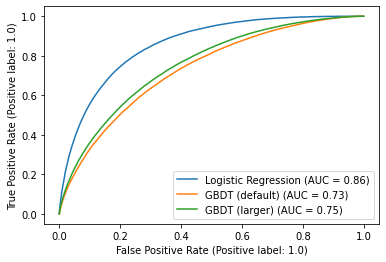

In [105]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(logreg_pipeline, X_test, y_test, ax=ax, name='Logistic Regression')
RocCurveDisplay.from_estimator(hgbc, X_test, y_test, ax=ax, name='GBDT (default)')
RocCurveDisplay.from_estimator(xgbc_large, X_test, y_test, ax=ax, name='GBDT (larger)')
fig.show()

In [81]:
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
566853,395,334,346,50,19,294,216,268,0,194,11,99,0,68,0
382311,562,102,187,18,0,314,393,624,0,139,14,250,0,52,109
241519,377,188,524,80,15,186,149,0,13,0,3,117,0,27,0
719220,0,0,0,60,18,125,61,406,3,0,11,0,213,40,0
905718,0,149,273,29,20,0,388,595,0,113,17,0,436,109,185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,97,0,182,43,7,173,338,545,2,0,7,242,266,57,0
365838,267,253,202,65,0,45,260,535,0,90,12,44,419,0,83
131932,352,0,0,34,11,223,58,451,0,197,15,264,351,8,205
671155,208,422,451,44,13,260,0,0,0,228,8,191,188,0,160


In [111]:
y_train

array([0., 1., 0., ..., 1., 0., 1.])

In [112]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,179,78,159,46,18,0,174,428,17,137,19,59,0,51,0
1,598,623,0,0,5,0,218,403,10,58,17,52,160,82,95
2,610,536,420,36,16,186,0,281,0,124,21,0,348,56,0
3,0,503,0,51,0,215,133,550,14,228,3,47,313,91,59
4,239,381,381,35,16,146,190,451,14,111,6,0,36,78,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,409,536,390,58,16,0,148,270,16,183,11,131,278,114,260
999996,372,408,409,38,17,125,343,801,0,107,0,0,406,0,35
999997,0,211,439,0,0,0,278,268,19,149,9,282,196,53,215
999998,160,440,0,33,11,0,276,201,13,119,14,0,39,0,70


# SAVE THE DATASET

In [108]:
import os

In [109]:
user = os.getenv("USER")

In [124]:
path=f"/home/{user}/persistent_drive/pytorch-tensorfm/data/test-datasets/syntetic_interaction_trees"

In [122]:
df['label'] = labels

In [123]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,labels
0,179,78,159,46,18,0,174,428,17,137,19,59,0,51,0,0.0
1,598,623,0,0,5,0,218,403,10,58,17,52,160,82,95,0.0
2,610,536,420,36,16,186,0,281,0,124,21,0,348,56,0,0.0
3,0,503,0,51,0,215,133,550,14,228,3,47,313,91,59,0.0
4,239,381,381,35,16,146,190,451,14,111,6,0,36,78,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,409,536,390,58,16,0,148,270,16,183,11,131,278,114,260,0.0
999996,372,408,409,38,17,125,343,801,0,107,0,0,406,0,35,0.0
999997,0,211,439,0,0,0,278,268,19,149,9,282,196,53,215,0.0
999998,160,440,0,33,11,0,276,201,13,119,14,0,39,0,70,0.0


In [125]:
df_permuted = df.sample(frac=1).reset_index(drop=True)

In [126]:
df_permuted

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,labels
0,0,433,438,38,13,293,0,499,0,148,13,0,237,65,67,0.0
1,585,0,280,57,3,337,208,633,0,0,7,144,385,70,245,0.0
2,292,339,592,0,0,311,160,453,17,164,0,218,0,15,181,0.0
3,297,305,0,36,9,0,274,578,10,0,16,141,351,64,206,1.0
4,273,210,363,48,20,378,176,403,11,135,13,0,161,31,185,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0,466,15,14,236,127,335,24,142,0,291,439,0,95,0.0
999996,0,322,305,17,0,0,225,0,21,151,20,0,411,75,0,0.0
999997,55,690,267,43,11,182,354,405,18,0,0,232,295,0,166,1.0
999998,340,257,34,23,16,0,134,0,17,144,14,270,333,80,210,0.0


In [127]:
# train, test, validation rel. sizes and indices inside the single common dataframe
num_rows = 1000000
train_size = 0.8
test_size = 0.1
validation_size = 0.1

train_st = 0
train_end = int(train_size * num_rows)
test_st = (num_rows-int(test_size * num_rows))
test_end = num_rows
validation_st = (num_rows-int((validation_size + test_size) * num_rows))
validation_end = test_st

In [128]:
df[train_st:train_end].to_csv(f"{path}/train.csv", index=False)
df[validation_st:validation_end].to_csv(f"{path}/validation.csv", index=False)
df[test_st:test_end].to_csv(f"{path}/test.csv", index=False)